# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

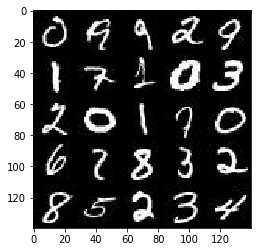

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

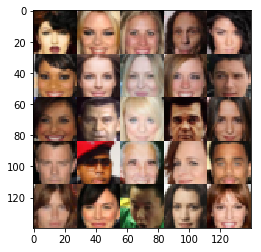

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32,
                                  [None, image_width, image_height, image_channels],
                                  name='input_images')
    z = tf.placeholder(tf.float32, [None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    def leaky_relu(x):
        return tf.maximum(x, 0.01 * x)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 14x14x32
        conv1 = tf.layers.conv2d(images, filters=32, kernel_size=5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = leaky_relu(conv1)
        
        # 7x7x64
        conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_relu(conv2)
        
        # 4x4x128
        conv3 = tf.layers.conv2d(conv2, filters=128, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_relu(conv3)
        
        flat = tf.reshape(conv3, (-1, 4 * 4 * 128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    def leaky_relu(x):
        return tf.maximum(x, 0.01 * x)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # 4x4x512
        conv1 = tf.layers.dense(z, 4 * 4 * 512)
        conv1 = tf.reshape(conv1, [-1, 4, 4, 512])
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leaky_relu(conv1)
        
        # 7x7x256
        conv2 = tf.layers.conv2d_transpose(conv1, filters=256, kernel_size=4, strides=1, padding='valid')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = leaky_relu(conv2)
        
        # 14x14x128
        conv3 = tf.layers.conv2d_transpose(conv2, filters=128, kernel_size=5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = leaky_relu(conv3)
        
        # 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(conv3, filters=out_channel_dim,
                                            kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_real),
                                                logits=d_logits_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_model_fake),
                                                logits=d_logits_fake))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_fake),
                                                logits=d_logits_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
            .minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1) \
            .minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, _ = data_shape
    n_channels = len(data_image_mode)
    
    input_images, z, learning_rate_ = model_inputs(image_width=width,
                                                   image_height=height,
                                                   image_channels=n_channels,
                                                   z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real=input_images,
                                input_z=z,
                                out_channel_dim=n_channels)
    d_train_opt, g_train_opt = model_opt(d_loss=d_loss,
                                         g_loss=g_loss,
                                         learning_rate=learning_rate_,
                                         beta1=beta1)
    
    print_every=10
    show_every=100
    
    global losses
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_images: batch_images,
                                                 z: batch_z,
                                                 learning_rate_: learning_rate})
                sess.run(g_train_opt, feed_dict={input_images: batch_images,
                                                 z: batch_z,
                                                 learning_rate_: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({z: batch_z})
                    print('Epoch {}/{}...'.format(epoch_i + 1, epochs),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess=sess,
                                          n_images=25,
                                          input_z=z,
                                          out_channel_dim=n_channels,
                                          image_mode=data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2774... Generator Loss: 8.0535
Epoch 1/2... Discriminator Loss: 0.3420... Generator Loss: 1.2916
Epoch 1/2... Discriminator Loss: 0.0647... Generator Loss: 7.4208
Epoch 1/2... Discriminator Loss: 0.0235... Generator Loss: 5.7228
Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 8.9212
Epoch 1/2... Discriminator Loss: 0.0654... Generator Loss: 5.1753
Epoch 1/2... Discriminator Loss: 0.0938... Generator Loss: 3.2268
Epoch 1/2... Discriminator Loss: 7.5682... Generator Loss: 0.0050
Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 1.8993
Epoch 1/2... Discriminator Loss: 0.1554... Generator Loss: 3.6882


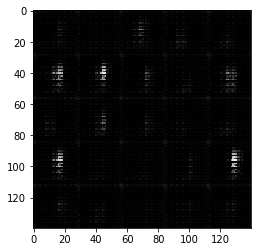

Epoch 1/2... Discriminator Loss: 0.1772... Generator Loss: 2.5480
Epoch 1/2... Discriminator Loss: 0.4955... Generator Loss: 1.9533
Epoch 1/2... Discriminator Loss: 0.2976... Generator Loss: 3.9373
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 2.0069
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 3.7480
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 0.2963... Generator Loss: 2.1462
Epoch 1/2... Discriminator Loss: 0.3663... Generator Loss: 2.3996
Epoch 1/2... Discriminator Loss: 0.5279... Generator Loss: 6.8530
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 2.2427


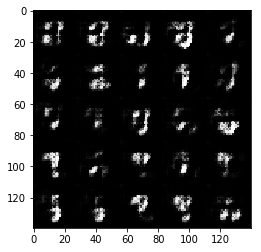

Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 2.6055
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 1.4448
Epoch 1/2... Discriminator Loss: 0.4484... Generator Loss: 2.3283
Epoch 1/2... Discriminator Loss: 0.3424... Generator Loss: 2.8690
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 3.2932
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 2.3655
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 3.6511
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 2.1426


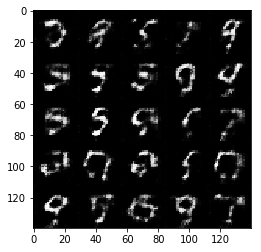

Epoch 1/2... Discriminator Loss: 1.9749... Generator Loss: 0.2244
Epoch 1/2... Discriminator Loss: 0.4679... Generator Loss: 1.9321
Epoch 1/2... Discriminator Loss: 0.2721... Generator Loss: 4.4434
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 1.2776
Epoch 1/2... Discriminator Loss: 0.1288... Generator Loss: 3.4742
Epoch 1/2... Discriminator Loss: 7.0759... Generator Loss: 11.8593
Epoch 1/2... Discriminator Loss: 0.2627... Generator Loss: 1.8673
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 8.5113
Epoch 1/2... Discriminator Loss: 0.2509... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 0.2629... Generator Loss: 1.7898


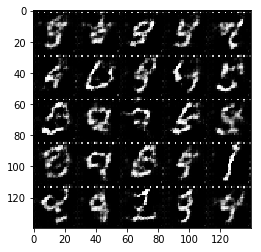

Epoch 1/2... Discriminator Loss: 0.0459... Generator Loss: 4.3249
Epoch 1/2... Discriminator Loss: 0.0219... Generator Loss: 4.8028
Epoch 1/2... Discriminator Loss: 0.0288... Generator Loss: 5.6366
Epoch 1/2... Discriminator Loss: 0.0237... Generator Loss: 4.9965
Epoch 1/2... Discriminator Loss: 0.0153... Generator Loss: 5.8310
Epoch 1/2... Discriminator Loss: 0.0129... Generator Loss: 5.0302
Epoch 1/2... Discriminator Loss: 0.0375... Generator Loss: 3.4823
Epoch 1/2... Discriminator Loss: 0.0105... Generator Loss: 5.2293
Epoch 1/2... Discriminator Loss: 0.0181... Generator Loss: 5.7395
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 1.5892


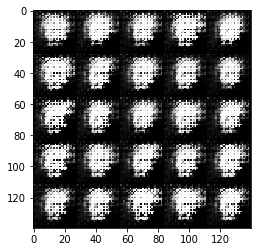

Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 2.4272
Epoch 1/2... Discriminator Loss: 0.1142... Generator Loss: 3.7230
Epoch 1/2... Discriminator Loss: 0.1826... Generator Loss: 2.5888
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.5398
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 2.1908
Epoch 1/2... Discriminator Loss: 0.3410... Generator Loss: 6.5830
Epoch 1/2... Discriminator Loss: 0.1553... Generator Loss: 2.4811
Epoch 1/2... Discriminator Loss: 0.1241... Generator Loss: 2.8742
Epoch 1/2... Discriminator Loss: 0.1148... Generator Loss: 2.8583
Epoch 1/2... Discriminator Loss: 0.0513... Generator Loss: 4.2635


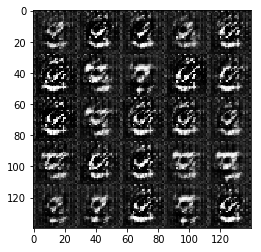

Epoch 1/2... Discriminator Loss: 0.0442... Generator Loss: 4.5064
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 3.9127
Epoch 1/2... Discriminator Loss: 0.2410... Generator Loss: 2.6337
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 0.1929... Generator Loss: 3.6228
Epoch 1/2... Discriminator Loss: 0.0955... Generator Loss: 2.9591
Epoch 1/2... Discriminator Loss: 0.1398... Generator Loss: 2.6157
Epoch 1/2... Discriminator Loss: 0.6160... Generator Loss: 3.5376
Epoch 1/2... Discriminator Loss: 0.2075... Generator Loss: 3.5743
Epoch 1/2... Discriminator Loss: 0.3423... Generator Loss: 1.7634


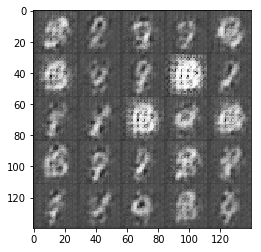

Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.2248
Epoch 1/2... Discriminator Loss: 0.4530... Generator Loss: 1.9842
Epoch 1/2... Discriminator Loss: 0.2954... Generator Loss: 2.3441
Epoch 1/2... Discriminator Loss: 0.4548... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 0.2302... Generator Loss: 4.7766
Epoch 1/2... Discriminator Loss: 0.4046... Generator Loss: 1.6212
Epoch 1/2... Discriminator Loss: 0.2908... Generator Loss: 1.7877
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 0.1200... Generator Loss: 4.6476
Epoch 1/2... Discriminator Loss: 0.2486... Generator Loss: 1.9496


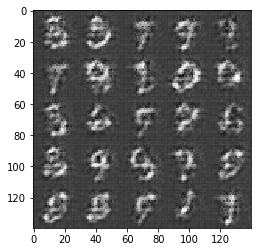

Epoch 1/2... Discriminator Loss: 0.2890... Generator Loss: 1.8221
Epoch 1/2... Discriminator Loss: 6.1736... Generator Loss: 10.1606
Epoch 1/2... Discriminator Loss: 0.4355... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 0.5051... Generator Loss: 1.4569
Epoch 1/2... Discriminator Loss: 0.5509... Generator Loss: 2.1584
Epoch 1/2... Discriminator Loss: 0.1945... Generator Loss: 2.2242
Epoch 1/2... Discriminator Loss: 3.3826... Generator Loss: 6.9486
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 1.2468
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 0.7298... Generator Loss: 0.9396


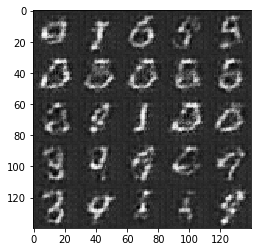

Epoch 1/2... Discriminator Loss: 0.5322... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 1.8689
Epoch 1/2... Discriminator Loss: 0.2021... Generator Loss: 3.2183
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 2.1074
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 0.2408... Generator Loss: 2.4799
Epoch 2/2... Discriminator Loss: 0.4586... Generator Loss: 1.2171
Epoch 2/2... Discriminator Loss: 0.3325... Generator Loss: 3.4509
Epoch 2/2... Discriminator Loss: 0.1667... Generator Loss: 2.3190
Epoch 2/2... Discriminator Loss: 1.5950... Generator Loss: 4.2590


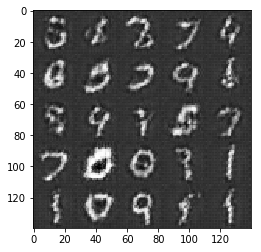

Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 2.2017
Epoch 2/2... Discriminator Loss: 0.5763... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 0.1954... Generator Loss: 2.3864
Epoch 2/2... Discriminator Loss: 0.2125... Generator Loss: 2.2220
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 1.4311... Generator Loss: 1.5311
Epoch 2/2... Discriminator Loss: 1.1171... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 0.5738... Generator Loss: 1.4070
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 0.9501


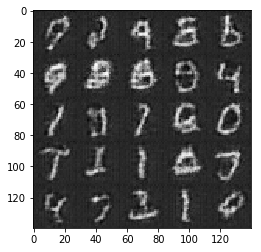

Epoch 2/2... Discriminator Loss: 0.3736... Generator Loss: 2.2437
Epoch 2/2... Discriminator Loss: 0.3318... Generator Loss: 2.6115
Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 2.6055
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 1.9680
Epoch 2/2... Discriminator Loss: 0.3771... Generator Loss: 1.4469
Epoch 2/2... Discriminator Loss: 0.1555... Generator Loss: 4.1486
Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 2.3048... Generator Loss: 0.1651
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 1.1831


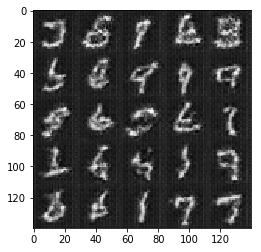

Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.3119
Epoch 2/2... Discriminator Loss: 0.6214... Generator Loss: 1.1710
Epoch 2/2... Discriminator Loss: 0.5537... Generator Loss: 1.6184
Epoch 2/2... Discriminator Loss: 0.5712... Generator Loss: 1.2814
Epoch 2/2... Discriminator Loss: 0.3527... Generator Loss: 1.5335
Epoch 2/2... Discriminator Loss: 0.1981... Generator Loss: 2.5735
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.1257
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 2.2857
Epoch 2/2... Discriminator Loss: 0.5281... Generator Loss: 1.6669


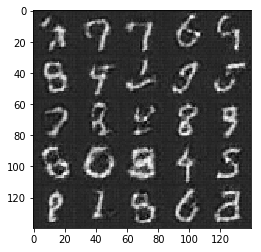

Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 0.1297... Generator Loss: 3.4789
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.5990
Epoch 2/2... Discriminator Loss: 0.3103... Generator Loss: 2.4271
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 0.6832
Epoch 2/2... Discriminator Loss: 0.1897... Generator Loss: 2.4134
Epoch 2/2... Discriminator Loss: 0.2756... Generator Loss: 1.9464
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.6829


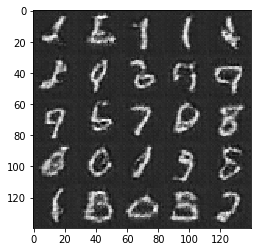

Epoch 2/2... Discriminator Loss: 0.6663... Generator Loss: 1.1387
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 2.0650
Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 1.2656
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 1.4358
Epoch 2/2... Discriminator Loss: 0.1880... Generator Loss: 3.5405
Epoch 2/2... Discriminator Loss: 1.9160... Generator Loss: 5.5040
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.0715
Epoch 2/2... Discriminator Loss: 0.1328... Generator Loss: 2.7593


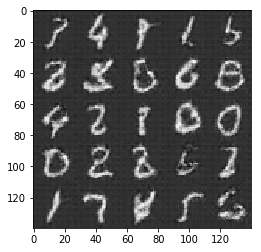

Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 1.6474
Epoch 2/2... Discriminator Loss: 0.3124... Generator Loss: 2.0133
Epoch 2/2... Discriminator Loss: 0.1300... Generator Loss: 2.6832
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 1.0354... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 1.9692
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 2.0941
Epoch 2/2... Discriminator Loss: 1.2801... Generator Loss: 0.4735


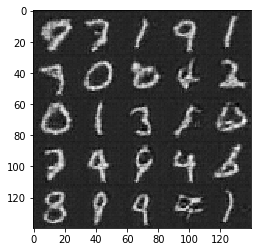

Epoch 2/2... Discriminator Loss: 0.9476... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 0.5644... Generator Loss: 1.2835
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 0.6872... Generator Loss: 1.4339
Epoch 2/2... Discriminator Loss: 0.7762... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 1.9209... Generator Loss: 3.6034
Epoch 2/2... Discriminator Loss: 0.8678... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 1.6082


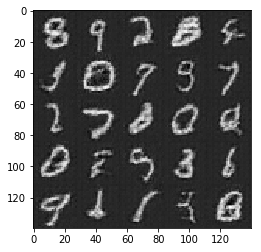

Epoch 2/2... Discriminator Loss: 0.4108... Generator Loss: 1.5563
Epoch 2/2... Discriminator Loss: 2.9851... Generator Loss: 0.0867
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 0.5255... Generator Loss: 1.3873
Epoch 2/2... Discriminator Loss: 2.1719... Generator Loss: 0.1913
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.5512
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 2.0464... Generator Loss: 3.6042
Epoch 2/2... Discriminator Loss: 0.4092... Generator Loss: 1.6483


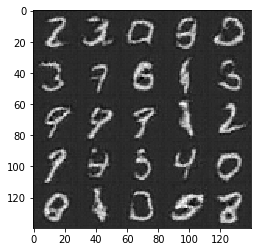

Epoch 2/2... Discriminator Loss: 0.2697... Generator Loss: 2.5658
Epoch 2/2... Discriminator Loss: 1.1219... Generator Loss: 0.6099
Epoch 2/2... Discriminator Loss: 0.7794... Generator Loss: 1.0137
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.1368
Epoch 2/2... Discriminator Loss: 0.5043... Generator Loss: 1.8950
Epoch 2/2... Discriminator Loss: 0.5676... Generator Loss: 1.1330
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.6104


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.